In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Read the dataset
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
df=pd.read_csv('/content/drive/My Drive/Fuel_cell_performance_data-Full.csv')

In [5]:
df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,F11,F12,F13,F14,F15,Target1,Target2,Target3,Target4,Target5
0,52.9,1.33,49.1,37.13,129.43,35.0,0.281,112.7,207,0.55,98.971,2.87,1362,15.9,429,0.959,1.531,79.3,4.19,33.29
1,87.6,2.12,48.8,42.10,171.07,37.6,0.153,157.4,188,0.86,101.179,2.34,5130,26.1,1819,0.728,1.690,57.2,5.19,34.50
2,73.3,2.72,93.8,20.11,163.69,44.3,0.367,348.7,270,1.87,98.919,2.13,7811,16.7,1763,0.784,1.865,61.6,7.77,129.28
3,65.6,2.58,48.1,35.11,63.37,32.5,0.279,321.2,322,1.75,101.560,2.91,1641,32.1,203,0.884,1.920,71.3,8.40,186.65
4,39.6,2.58,49.3,32.93,63.40,47.0,0.149,205.6,203,1.55,98.148,1.93,7648,27.5,276,0.736,1.711,58.5,4.75,52.32


In [6]:
roll_number = 102203900
last_digit = roll_number % 10

**Pre-process the dataset**

In [7]:
# check for null values
for col in df.columns:
  if df[col].isnull().sum() > 0:
    df[col] = df[col].fillna(df[col].mean())
print("Total null values:", df.isnull().sum().sum())

Total null values: 0


In [8]:
df = df.select_dtypes(include=['number'])

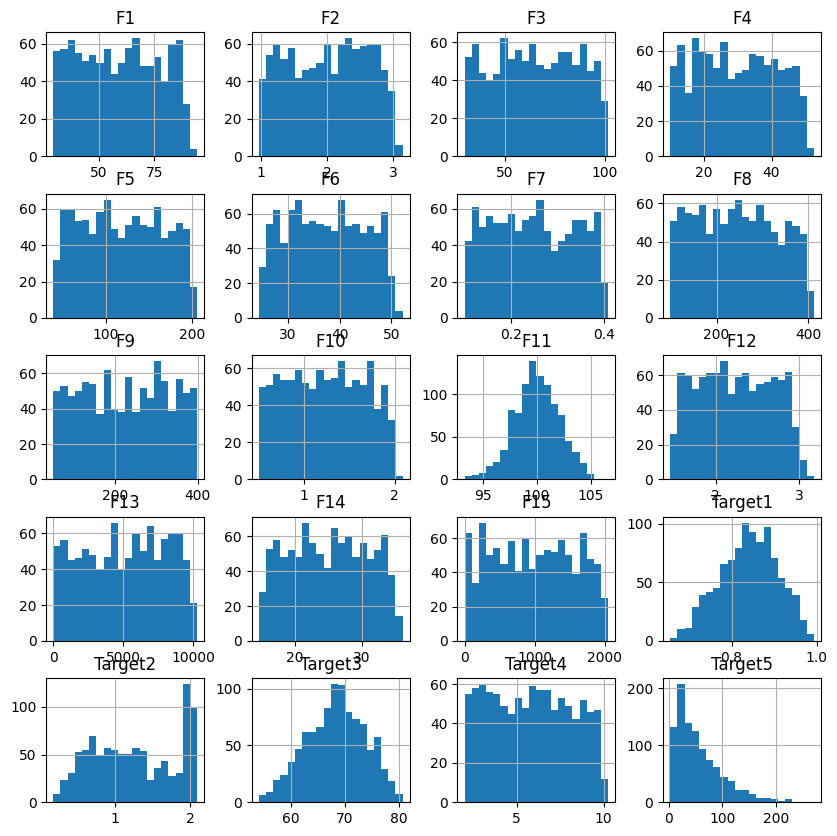

In [8]:
df.hist(bins=20, figsize=(10, 10))
plt.show()

In [9]:
for col in df.columns:
  if df[col].dtype == 'object':
    df[col] = pd.to_numeric(df[col], errors='coerce')

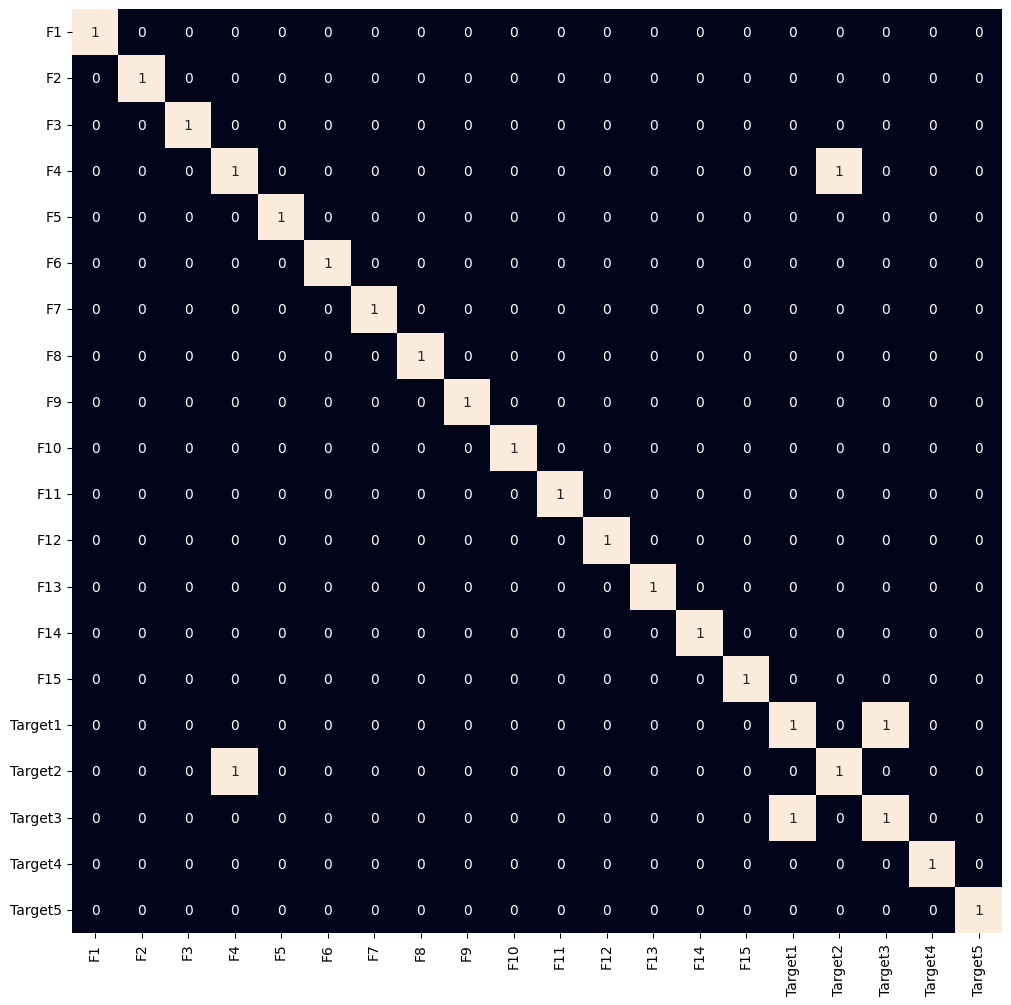

In [10]:
corr = df.corr()
plt.figure(figsize=(12, 12))
sns.heatmap(corr > 0.7, annot=True, cbar=False)
plt.show()

In [11]:
print(df.columns)

Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'Target1', 'Target2', 'Target3', 'Target4',
       'Target5'],
      dtype='object')


In [12]:
df['Target'] = df['Target1']
df = df.drop(columns=['Target2','Target3','Target4','Target5','Target1'])

In [1]:
# install pycaret to compare models
!pip install pycaret

In [13]:
print(df['Target'].value_counts())

Target
0.857    11
0.872    11
0.868    10
0.896    10
0.838    10
         ..
0.696     1
0.716     1
0.963     1
0.983     1
0.752     1
Name: count, Length: 281, dtype: int64


In [14]:
from pycaret.regression import setup, compare_models, pull, finalize_model, predict_model

In [15]:
# Initialize for regression
reg_setup = setup(data=df, target='Target', session_id=42, preprocess=True, verbose=False)

In [16]:
print(df.columns)

Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'Target'],
      dtype='object')


In [17]:
best_models = compare_models(sort='R2', n_select=10, fold=5)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
br,Bayesian Ridge,0.0507,0.0036,0.0603,0.1909,0.0329,0.0613,0.0240
ridge,Ridge Regression,0.0509,0.0037,0.0606,0.1837,0.0331,0.0615,0.0380
lr,Linear Regression,0.0509,0.0037,0.0606,0.1821,0.0331,0.0616,1.3140
lar,Least Angle Regression,0.0510,0.0037,0.0607,0.1805,0.0331,0.0616,0.0220
rf,Random Forest Regressor,0.0517,0.0038,0.0619,0.1461,0.0338,0.0625,0.6080
et,Extra Trees Regressor,0.0518,0.0039,0.0621,0.1417,0.0339,0.0626,0.3120
ada,AdaBoost Regressor,0.0522,0.0039,0.0622,0.1389,0.0339,0.0629,0.1620
omp,Orthogonal Matching Pursuit,0.0534,0.0041,0.0639,0.0949,0.0349,0.0646,0.0260
llar,Lasso Least Angle Regression,0.0534,0.0041,0.0639,0.0941,0.0349,0.0647,0.0260
lasso,Lasso Regression,0.0534,0.0041,0.0639,0.0941,0.0349,0.0647,0.0420


Processing:   0%|          | 0/90 [00:00<?, ?it/s]

In [18]:
results = pull()
results = results[['Model', 'R2', 'RMSE', 'MAE']]
print(results)

                                    Model      R2    RMSE     MAE
br                         Bayesian Ridge  0.1909  0.0603  0.0507
ridge                    Ridge Regression  0.1837  0.0606  0.0509
lr                      Linear Regression  0.1821  0.0606  0.0509
lar                Least Angle Regression  0.1805  0.0607  0.0510
rf                Random Forest Regressor  0.1461  0.0619  0.0517
et                  Extra Trees Regressor  0.1417  0.0621  0.0518
ada                    AdaBoost Regressor  0.1389  0.0622  0.0522
omp           Orthogonal Matching Pursuit  0.0949  0.0639  0.0534
llar         Lasso Least Angle Regression  0.0941  0.0639  0.0534
lasso                    Lasso Regression  0.0941  0.0639  0.0534
en                            Elastic Net  0.0941  0.0639  0.0534
gbr           Gradient Boosting Regressor  0.0781  0.0645  0.0538
lightgbm  Light Gradient Boosting Machine  0.0237  0.0662  0.0548
dummy                     Dummy Regressor -0.0055  0.0675  0.0558
xgboost   

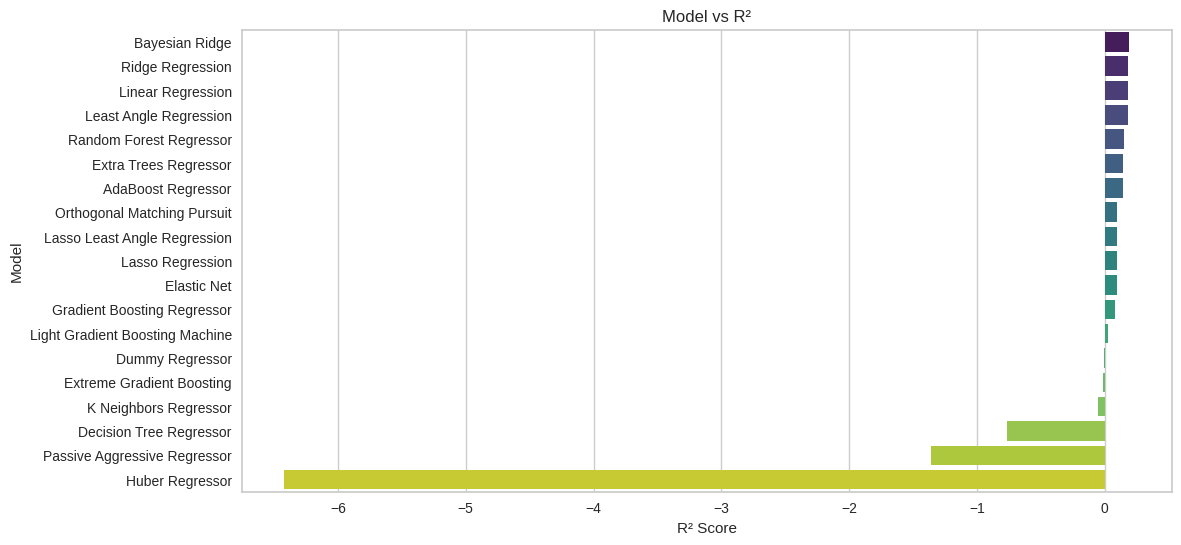

In [19]:
# Plot Model vs R2
plt.figure(figsize=(12, 6))
sns.barplot(x='R2', y='Model', data=results, palette='viridis')
plt.xlabel("R² Score")
plt.ylabel("Model")
plt.title("Model vs R²")
plt.show()

In [20]:
X = df.drop(columns=['Target'])
y = df['Target']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.7, random_state=42)

train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)
final_model = finalize_model(best_models[0])

In [21]:
predictions = predict_model(final_model, data=test_data)
print("Predictions and Evaluation on Test Data:")
print(predictions.head())

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.0487,0.0034,0.0582,0.2514,0.0318,0.0591


Predictions and Evaluation on Test Data:
            F1    F2         F3         F4          F5         F6     F7  \
521  53.299999  2.96  39.799999  29.850000  132.610001  39.200001  0.168   
737  79.400002  1.34  67.699997  38.540001   95.220001  31.799999  0.100   
740  57.400002  2.64  57.200001  47.099998  153.100006  46.599998  0.156   
660  52.299999  2.27  64.099998  29.330000  123.169998  30.000000  0.266   
411  87.199997  1.24  40.599998  15.390000   40.860001  32.099998  0.202   

             F8   F9   F10         F11   F12   F13        F14   F15  Target  \
521  250.199997  148  0.99   98.070000  2.33  5382  23.500000  1706   0.756   
737  163.300003  198  0.99  102.834999  2.15  7648  26.299999  1675   0.900   
740  268.100006  294  1.73  101.441002  1.90   852  25.799999  1203   0.942   
660  108.099998  385  1.54  100.304001  2.82  8513  18.400000  1641   0.853   
411  232.600006  302  1.54   99.363998  2.82  5708  23.100000   428   0.855   

     prediction_label  
521

In [22]:
predictions = predict_model(final_model, data=test_data)
print("Columns returned by predict_model:", predictions.columns)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Bayesian Ridge,0.0487,0.0034,0.0582,0.2514,0.0318,0.0591


Columns returned by predict_model: Index(['F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'F9', 'F10', 'F11',
       'F12', 'F13', 'F14', 'F15', 'Target', 'prediction_label'],
      dtype='object')


In [23]:
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
r2 = r2_score(predictions['Target'], predictions['prediction_label'])
mse = mean_squared_error(predictions['Target'], predictions['prediction_label'])
rmse = np.sqrt(mse)
mae = mean_absolute_error(predictions['Target'], predictions['prediction_label'])
print("R²:", r2)
print("RMSE:", rmse)
print("MAE:", mae)

R²: 0.25144831280889857
RMSE: 0.05822574712711292
MAE: 0.048706553893365076
